In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, recall_score


In [89]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**Problem Statement:**

Company X deals in all home loans. They have a presence across all urban, semi-urban, and rural areas. A customer applies for a home loan, and then the company validates the customer's eligibility for a loan.

The company wants to automate the loan eligibility process (real-time) based on customer details provided while filling the online application form. These details are gender, marital status, education, number of dependents, income, loan amount, credit history, and others.

To automate this process, the aim of this project is to build a model that can identify the customer's segments, those eligible for the loan amount they have applied for, so that they can be specifically targeted to move forward with loan processing.


In [90]:
# Replace this with your actual data
df = pd.read_csv('/content/drive/MyDrive/loan_data [Task 1-3] - loan_data.csv')
df.head()


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [116]:
df.duplicated().sum()

np.int64(0)

In [92]:
df.isnull().sum()


,0
Loan_ID,0
Gender,13
Married,3
Dependents,15
Education,0
Self_Employed,32
ApplicantIncome,0
CoapplicantIncome,0
LoanAmount,22
Loan_Amount_Term,14


In [93]:
df.isnull().mean() * 100  # Percentage missing

,0
Loan_ID,0.000000
Gender,2.117264
Married,0.488599
Dependents,2.442997
Education,0.000000
Self_Employed,5.211726
ApplicantIncome,0.000000
CoapplicantIncome,0.000000
LoanAmount,3.583062
Loan_Amount_Term,2.280130


In [94]:
#drop married missing
df.dropna(subset=['Married'], inplace=True)

In [95]:
df['Dependents'].unique()

array(['0', '1', '2', '3+', nan], dtype=object)

In [96]:
df['Education'].unique()

array(['Graduate', 'Not Graduate'], dtype=object)

In [97]:
df.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [98]:
df["Loan_Status"].value_counts()

,count
Loan_Status,
Y,419
N,192


In [99]:
#impute missing values after train-test split to avoid data leakage (fit only on training data)

X = df.drop("Loan_Status", axis=1)  #
y = df["Loan_Status"]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# List of numeric column names - int and float
int_col=X_train.select_dtypes('integer').columns
print(int_col)

float_col = X_train.select_dtypes('float').columns
print(float_col)

#the 'number' value returns all numeric columns- integer columns and float
num_cols=X_train.select_dtypes('number').columns
num_cols

Index(['ApplicantIncome'], dtype='object')
Index(['CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term',
       'Credit_History'],
      dtype='object')


Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History'],
      dtype='object')

In [100]:
# Get the list of string column names
cat_cols= X_train.select_dtypes('object').columns
cat_cols

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'Property_Area'],
      dtype='object')

In [101]:
#handling missing values

#Detect skewness for  numeric train cols
skewness = X_train[num_cols].skew().abs()  #absolute skew
skew_threshold = 0.75  # common rule-of-thumb

num_median_cols = skewness[skewness > skew_threshold].index.tolist()   # skewed -> median
num_mean_cols   = skewness[skewness <= skew_threshold].index.tolist()  # approx normal -> mean

print("Mean-impute numeric cols:", num_mean_cols)
print("Median-impute numeric cols:", num_median_cols)

Mean-impute numeric cols: []
Median-impute numeric cols: ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']


In [102]:
#creat transformers
num_transformer = SimpleImputer(strategy='median')

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='MISSING')),
    ('encoder', OneHotEncoder(handle_unknown='ignore')) # all categorical columns are norminal
])

preprocessor = ColumnTransformer([
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
])


**Default Decision Tree**

In [103]:
# Encode Loan_Status value labels to 0/1
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [104]:
y_train

array([1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0,

Default Model Report:
               precision    recall  f1-score   support

           0       0.58      0.64      0.61        39
           1       0.82      0.79      0.80        84

    accuracy                           0.74       123
   macro avg       0.70      0.71      0.71       123
weighted avg       0.75      0.74      0.74       123



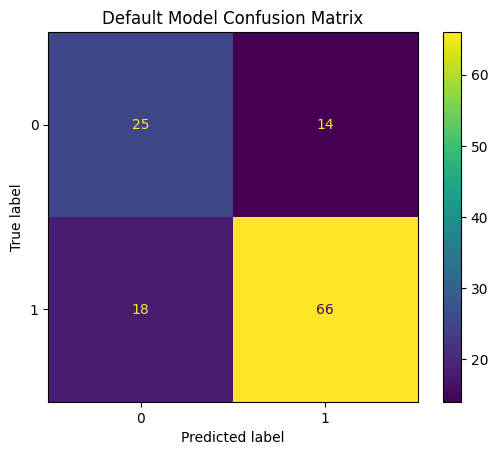

In [105]:
#Build, train, test & evaluate default Decision Tree

#model pipeline (for feature transformations)
default_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('tree', DecisionTreeClassifier(random_state=42))
])

default_pipeline.fit(X_train, y_train) #train

y_pred_default = default_pipeline.predict(X_test) #test

#evaluate
print("Default Model Report:\n", classification_report(y_test, y_pred_default))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_default)
plt.title("Default Model Confusion Matrix")
plt.show()


**Tuned Decision Tree**

In [106]:
#Tuned model

#Hyperparameter Tuning with GridSearchCV - model specific settings choosen before training. They control how the model learns
param_grid = {
    "model__max_depth": [3, 5, 10, None],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
    "model__criterion": ["gini", "entropy"]
}

# model pipeline: define a pipeline consisting of two steps: a preprocessing step (preprocessor)
# to transform the input features, followed by a DecisionTreeClassifier as the model.


grid_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", DecisionTreeClassifier(random_state=42))
])

#Set up a grid search to tune the model pipeline’s hyperparameters using 3-fold cross-validation, optimizing for macro recall

grid_search = GridSearchCV(
    estimator=grid_pipeline,  # model pipeline
    param_grid=param_grid,    # hyperparametrs
    cv=3,                     #3-folds
    scoring="recall_macro",  # Macro recall gives equal weight to both classes
    n_jobs=-1,
    verbose=1
)

#fit the grid_search object on the training data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         SimpleImputer(strategy='median'),
                                                                         Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History'],
      dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value='MISSING',
                                                                                                        strategy='constant')),
                                                                                         ('encoder',
                                                                                          OneH...
                                                                         Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'Property_Area'],
      dtype='object'))])),
                                       ('model',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__criterion': ['gini', 'entropy'],
                         'model__max_depth': [3, 5, 10, None],
                         'model__min_samples_leaf': [1, 2, 4],
                         'model__min_samples_split': [2, 5, 10]},
             scoring='recall_macro', verbose=1)

Tuned Decision Tree
Best Parameters: {'model__criterion': 'entropy', 'model__max_depth': 3, 'model__min_samples_leaf': 4, 'model__min_samples_split': 10}
              precision    recall  f1-score   support

           0       1.00      0.54      0.70        39
           1       0.82      1.00      0.90        84

    accuracy                           0.85       123
   macro avg       0.91      0.77      0.80       123
weighted avg       0.88      0.85      0.84       123



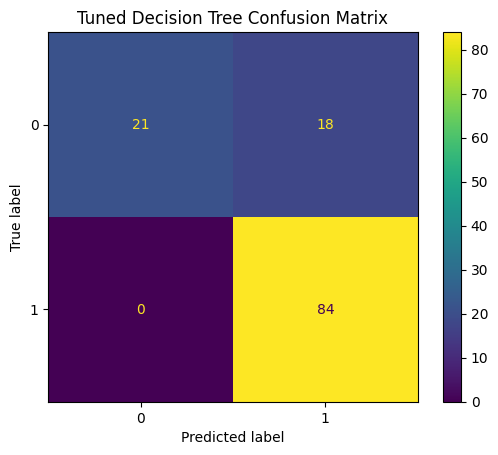

'\nTuned Decision Tree Model performance:\nThe Tuned Decision Tree Model performs  well in identifying Loan status Y making it highly\nsensitive to those with loans with a precision of 82%, recall of 100%, and f1-score of 90%.\nEven though the precision for N is 100%, recall for N is still low even after hyperparameter tuning.\nThe model only detects only 54% of real N class cases meaning it correctly catches only about half of the not-approved loans.\n\n\nOverall, the tuned decision tree performin well in identifying those eligible for loan (our focus)\n'

In [107]:
#Best Estimator

print("Tuned Decision Tree")
print("Best Parameters:", grid_search.best_params_)

#use the best model found by GridSearchCV to generate predictions
y_pred_tuned = grid_search.predict(X_test)



#Model Evaluation
#Classification report
print(classification_report(y_test, y_pred_tuned))

# Confusion matrix
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_tuned)).plot()
plt.title("Tuned Decision Tree Confusion Matrix")
plt.show()

#  Results Description
"""
Tuned Decision Tree Model performance:
The Tuned Decision Tree Model performs  well in identifying Loan status Y making it highly
sensitive to those with loans with a precision of 82%, recall of 100%, and f1-score of 90%.
Even though the precision for N is 100%, recall for N is still low even after hyperparameter tuning.
The model only detects only 54% of real N class cases meaning it correctly catches only about half of the not-approved loans.


Overall, the tuned decision tree performin well in identifying those eligible for loan (our focus)
"""


In [108]:
df['Loan_Status'].unique()

array(['Y', 'N'], dtype=object)

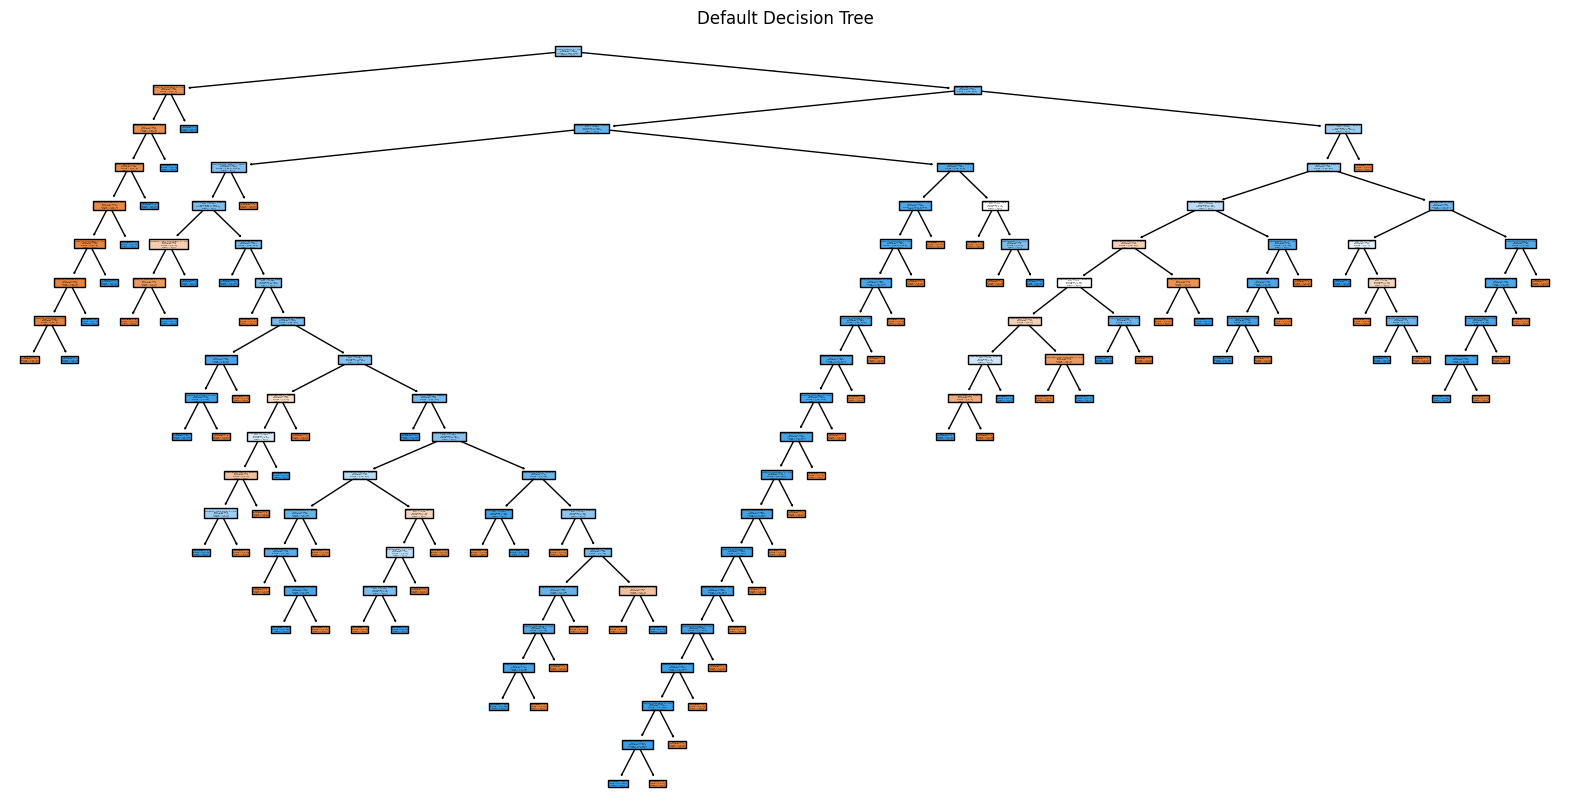

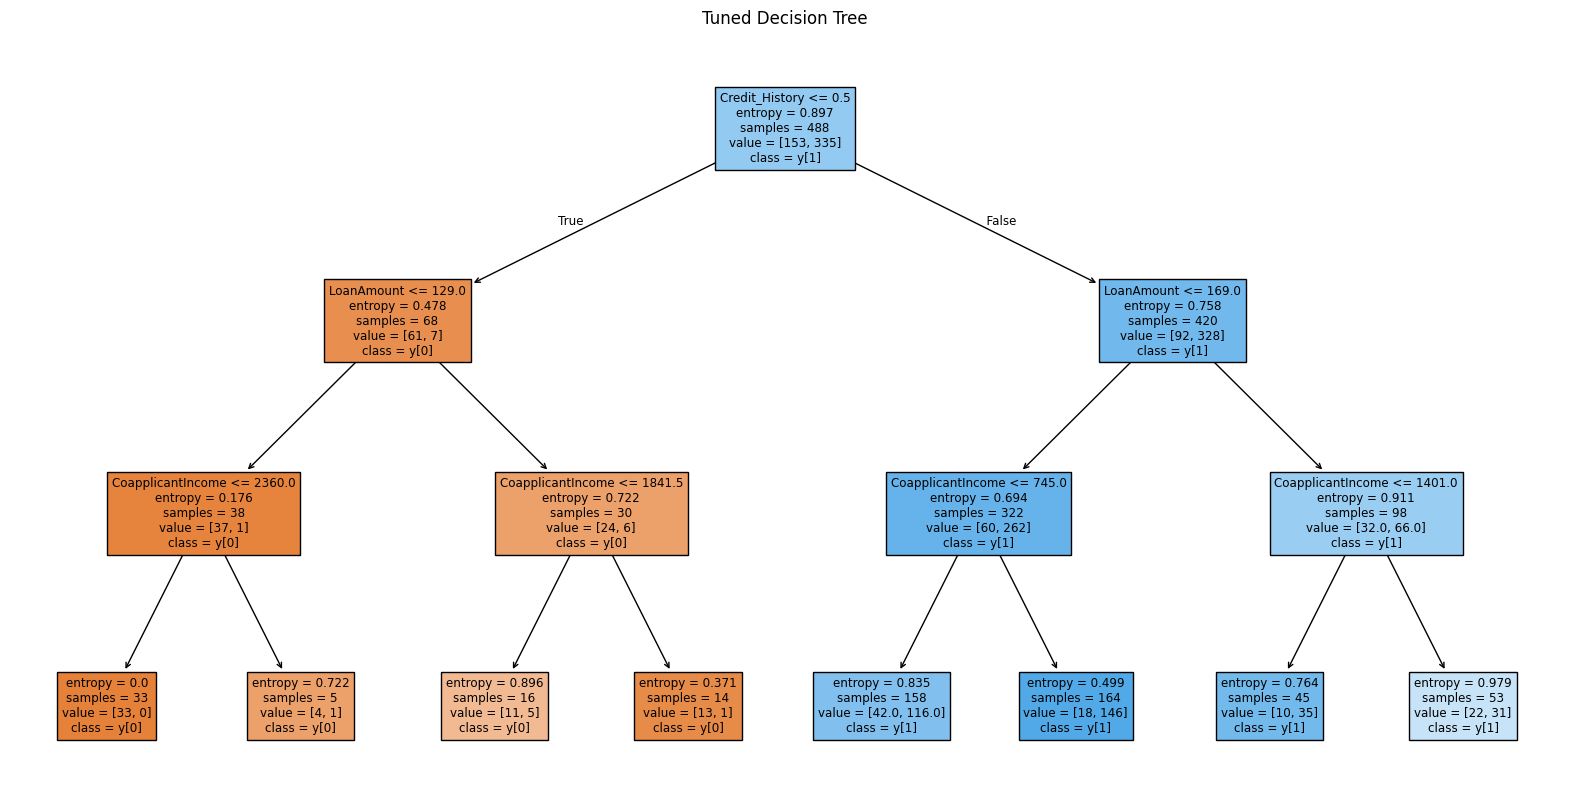

In [109]:
#Default and the tuned model Visualization

#preprocessor.fit(X_train)

# Getting the transformed numeric and categorical column names
num_features = preprocessor.transformers_[0][2]  # same as num_cols
cat_features_encoded = preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(cat_cols)

# Combining both num_cols and cat_cols to get all feature names for the tree
all_feature_names = list(num_features) + list(cat_features_encoded)

# Default Tree
plt.figure(figsize=(20, 10))
plot_tree(default_pipeline.named_steps['tree'], filled=True, feature_names=all_feature_names, class_names=True)
plt.title("Default Decision Tree")
plt.show()

# Tuned Tree
tuned_tree = grid_search.best_estimator_.named_steps["model"]

plt.figure(figsize=(20, 10))
plot_tree(tuned_tree, filled=True, feature_names=all_feature_names, class_names=True)
plt.title("Tuned Decision Tree")
plt.show()


In [110]:
print("Recall Macro (Default):", recall_score(y_test, y_pred_default, average='macro'))
print("Recall Macro (Tuned):", recall_score(y_test, y_pred_tuned, average='macro'))

print("\nBest Hyperparameters:")
print(grid_search.best_params_)


Recall Macro (Default): 0.7133699633699634
Recall Macro (Tuned): 0.7692307692307692

Best Hyperparameters:
{'model__criterion': 'entropy', 'model__max_depth': 3, 'model__min_samples_leaf': 4, 'model__min_samples_split': 10}


**Insights from the tree**

The Decision Tree was tuned to:

Use entropy (information gain) to split nodes (instead of default Gini).

Limit the tree depth to 3, which restricts complexity (helps generalization).

Require a minimum of 10 samples to split a node — reducing overfitting.

Require at least 4 samples at a leaf node, preventing the tree from growing too finely.


#**SVM**

Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        39
           1       0.68      1.00      0.81        84

    accuracy                           0.68       123
   macro avg       0.34      0.50      0.41       123
weighted avg       0.47      0.68      0.55       123



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


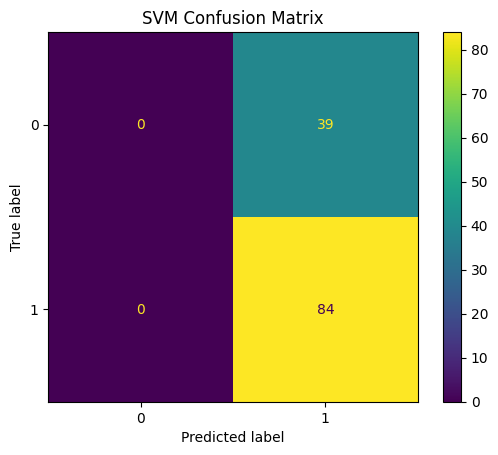

'\nModel performance:\nThe SVM model performs very well detcting real Loan status Y cases making it highly\nsensitive to those with loans. It performs extreemly poorly in identifying those not eligible for loan\n- class class N, 0% precision, recall, and f1-score\n- SVM precision, of 68% for class Y (those eligible for loan) - not so good.\n- Accuracy is also abit low but our effort could be directed to improving precision for Y\n  which would improve our F1-score\n'

In [111]:
# Train-test split - done
# Preprocessing pipeline - done


# SVM pipeline (for feature transformations)
svm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC())
])

# Train the model - SVM pipeline fit on training data
svm_pipeline.fit(X_train, y_train)

# Prediction
y_pred = svm_pipeline.predict(X_test)



# SVM model evaluation

# Classification Report
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(svm_pipeline, X_test, y_test)
plt.title("SVM Confusion Matrix")
plt.show()

#  Results Description
"""
Model performance:
The SVM model performs very well detcting real Loan status Y cases making it highly
sensitive to those with loans. It performs extreemly poorly in identifying those not eligible for loan
- class class N, 0% precision, recall, and f1-score
- SVM precision, of 68% for class Y (those eligible for loan) - not so good.
- Accuracy is also abit low but our effort could be directed to improving precision for Y
  which would improve our F1-score
"""


#**RANDOM FOREST**

Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.56      0.71        39
           1       0.83      0.99      0.90        84

    accuracy                           0.85       123
   macro avg       0.89      0.78      0.81       123
weighted avg       0.87      0.85      0.84       123



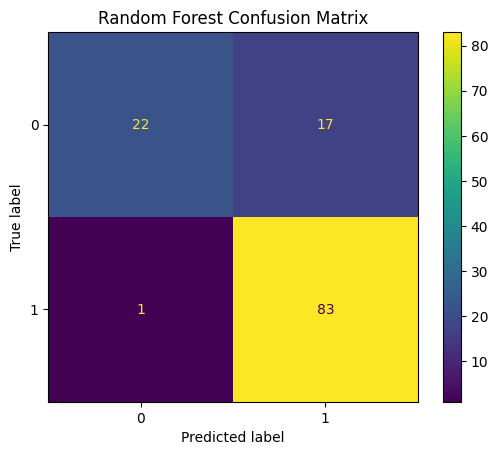

"\nModel performance:\nThe Random Forest model performs well in identifying Loan status Y making it highly\nsensitive to those approved for loans. Results are almost similar with those of tuned decision tree.\nIt perfoms better than SVM in identifying Loan status N. althogh recall for N is\nslightly low, detecting only 54% of real N cases it is way bettert than SVM's 0%.\n\nWith our focus being to identify customer's segments, specifically those eligible for loan\namount applied for (approved loans) so that they can be targeted, Random Forest is doing well\n- precision (83%), recall(99%), and f1-score(90)\n\n"

In [112]:
# Full pipeline with Random Forest
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state=42))
])

# Train the model
rf_pipeline.fit(X_train, y_train)

# Predict
y_pred = rf_pipeline.predict(X_test)

# Evaluate the model
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(rf_pipeline, X_test, y_test)
plt.title("Random Forest Confusion Matrix")
plt.show()

# Results
"""
Model performance:
The Random Forest model performs well in identifying Loan status Y making it highly
sensitive to those approved for loans. Results are almost similar with those of tuned decision tree.
It perfoms better than SVM in identifying Loan status N. althogh recall for N is
slightly low, detecting only 54% of real N cases it is way bettert than SVM's 0%.

With our focus being to identify customer's segments, specifically those eligible for loan
amount applied for (approved loans) so that they can be targeted, Random Forest is doing well
- precision (83%), recall(99%), and f1-score(90)

"""


 Training: Random Forest with GridSearchCV
Fitting 3 folds for each of 1008 candidates, totalling 3024 fits

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        39
           1       0.68      1.00      0.81        84

    accuracy                           0.68       123
   macro avg       0.34      0.50      0.41       123
weighted avg       0.47      0.68      0.55       123



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


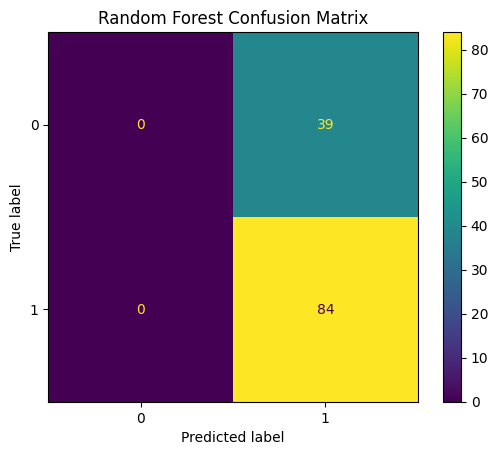

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [115]:

# Hyperparameter grid for Random Forest
rf_param_grid = {
    "model__n_estimators": [100, 200, 300, 500],
    "model__max_depth": [None,3, 5, 7, 10, 20, 30],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features": ["sqrt", "log2"],
    "model__class_weight": ["balanced", None]
}

# GridSearchCV with recall scoring
rf_grid = GridSearchCV(
    rf_pipeline,
    param_grid=rf_param_grid,
    scoring="recall",
    cv=3,
    n_jobs=-1,
    verbose=2
)

# Fit on training data
print("\n Training: Random Forest with GridSearchCV")
rf_grid.fit(X_train, y_train)

# Predictions
y_proba = rf_grid.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

# Evaluation
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(rf_grid, X_test, y_test)
plt.title("Random Forest Confusion Matrix")
plt.show()

# Results summary
report = classification_report(y_test, y_pred, output_dict=True)


In [114]:
rf_results = {
    "Best Params": rf_grid.best_params_
}

print("\n Random Forest Results:")
print(rf_results)


 Random Forest Results:
{'Best Params': {'model__class_weight': None, 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__n_estimators': 100}}
